In [2]:
import helper
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


In [3]:
# Not used
train_pipeline = Pipeline([
                    ("smote", OverSampler()),
                    ("normalizer", StandardScaler()) ])

## Half the data will be split out as validation and 0.2 as the test set

In [4]:

def get_split_index(features, labels, test_size=0.2):
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, original_labels, training_labels):
    train_index, validation_index = get_split_index(features, original_labels, test_size=0.5)[0]
    
    X_valid, y_valid, y_valid_original = features.iloc[validation_index],  training_labels.iloc[validation_index], original_labels.iloc[validation_index]
    X_train, y_train, y_original = features.iloc[train_index], training_labels.iloc[train_index], original_labels.iloc[train_index]
     
    return X_train, y_train, y_original, X_valid, y_valid, y_valid_original

def get_train_test_val(features, original_labels, training_labels):
    
    X, y, y_original, X_valid, y_valid, y_valid_original = split_valid(features,original_labels, training_labels)
   
    train_index, test_index = get_split_index(X, y_original)[0]
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    return X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original

### Train a DNN on the modified dataset

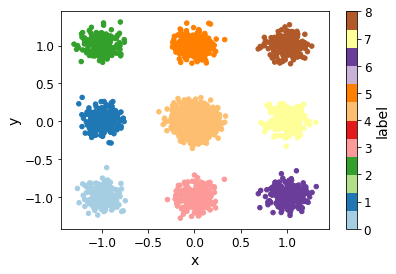

Train Size: (1600, 2)
Test Size: (400,)
Categories: [array([0, 1])]


In [5]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = helper.simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [6]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [7]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [8]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=100, batch_size=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 0s 144us/step - loss: 0.3528 - acc: 0.8969 - val_loss: 0.1820 - val_acc: 1.0000
Epoch 2/100
1600/1600 [==============================] - 0s 38us/step - loss: 0.1394 - acc: 1.0000 - val_loss: 0.1010 - val_acc: 1.0000
Epoch 3/100
1600/1600 [==============================] - 0s 38us/step - loss: 0.0860 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 4/100
1600/1600 [==============================] - 0s 37us/step - loss: 0.0606 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 1.0000
Epoch 5/100
1600/1600 [==============================] - 0s 37us/step - loss: 0.0459 - acc: 1.0000 - val_loss: 0.0377 - val_acc: 1.0000
Epoch 6/100
1600/1600 [==============================] - 0s 36us/step - loss: 0.0366 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 1.0000
Epoch 7/100
1600

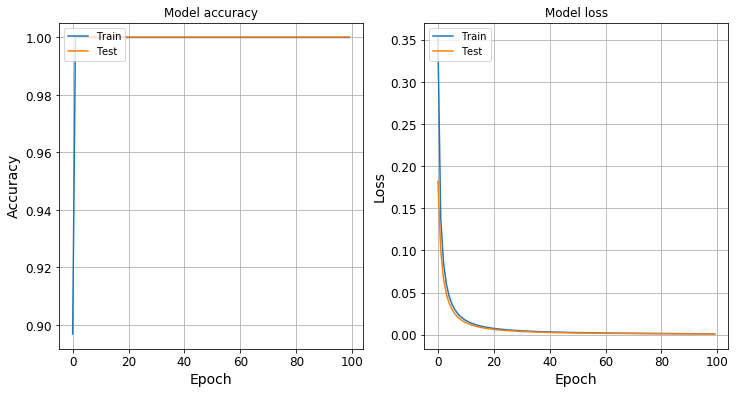

In [9]:
# Plotting results from history
plot_history(history)

In [10]:
preds = [x for x in nn.predict(Zscaler.transform(X_test[:5]))]
_labels = [np.float(x) for x in y_test]
preds[:5],_labels[:5]

([array([4.1514161e-04, 9.9958485e-01], dtype=float32),
  array([0.99885046, 0.0011495 ], dtype=float32),
  array([3.6666312e-04, 9.9963331e-01], dtype=float32),
  array([0.99832386, 0.00167619], dtype=float32),
  array([9.9971956e-01, 2.8040551e-04], dtype=float32)],
 [1.0, 0.0, 1.0, 0.0, 0.0])

## Performing SVM on Modded Samples

In [11]:
from sklearn.svm import LinearSVC

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM", LinearSVC(C=1, loss="hinge", max_iter=1000 ))
])

%time svm_clf.fit(X_train, y_train)
print("Linear SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_test, y_test)))

CPU times: user 12.1 ms, sys: 3.89 ms, total: 16 ms
Wall time: 5.29 ms
Linear SVM Test Accuracy: 0.688


## Performing LRP

In [12]:
import innvestigate
import innvestigate.utils as iutils

def perform_analysis(model, analyzer, data, labels=[]):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    df_anal = pd.DataFrame(analysis)
    
    return df_anal


scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)



# perform_analysis(nn,gradient_analyzer,flowers,types)
all_lrp_AB = perform_analysis(model,lrp_AB, all_samples)
all_lrp_E = perform_analysis(model,lrp_E, all_samples)
all_lrp_Z = perform_analysis(model,lrp_Z, all_samples)


Prediction Accuracy
2000/2000 [==============================] - 0s 9us/step
Scores on data set: loss=0.001 accuracy=1.0000
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [13]:
all_labels.value_counts()

4    1000
8     125
7     125
6     125
5     125
3     125
2     125
1     125
0     125
Name: label, dtype: int64

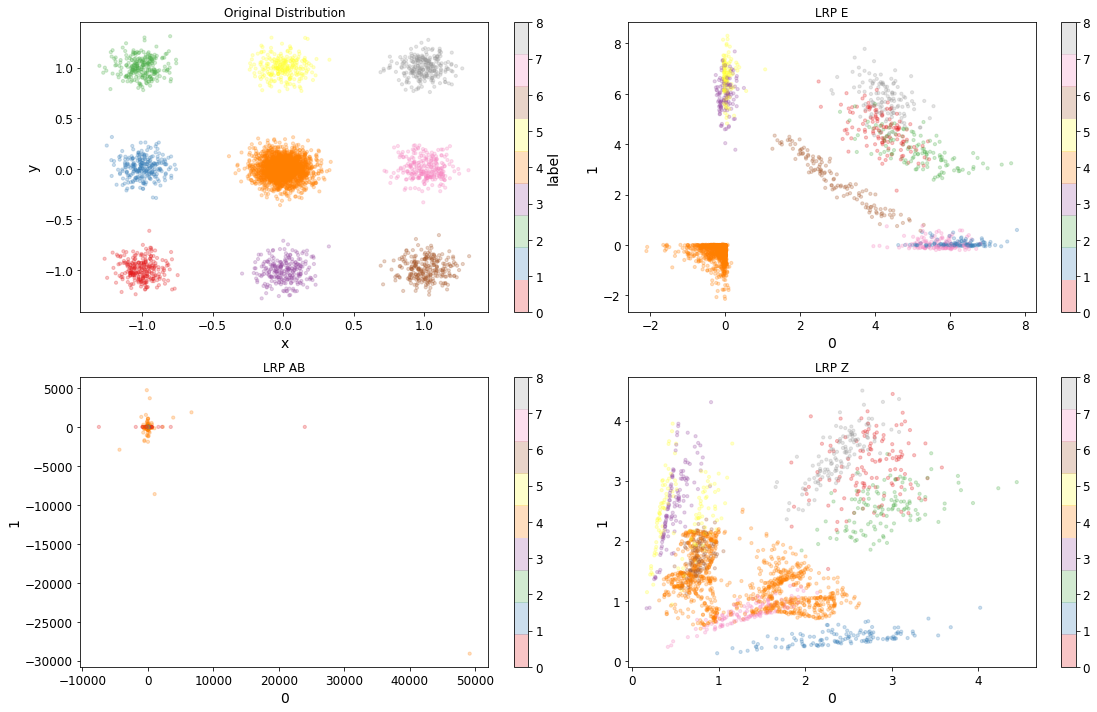

In [14]:
plt.close("Comparison")
fig, axs = plt.subplots(2,2, figsize=(16,10), num="Comparison")
cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}

original_data.plot(ax=axs[0][0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[0][1], title="LRP E", **plot_args)

all_lrp_AB.plot(ax=axs[1][0], title="LRP AB", **plot_args)
all_lrp_Z.plot(ax=axs[1][1], title="LRP Z", **plot_args)

plt.tight_layout()
plt.show()
# plt.savefig(figures_dir+"multiclass_lrp.png")

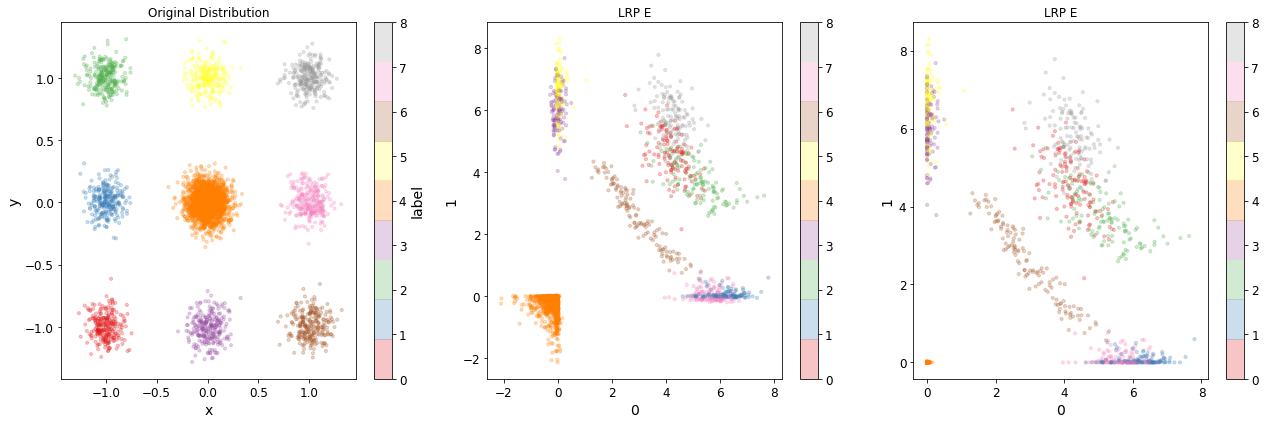

In [15]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

plot_args["c"] = "label"
original_data.plot(ax=axs[0], title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

In [36]:
plotSeparatedLRP(pos_lrp)

FigureCanvasNbAgg()

# Beginning Clustering using accelerated HDBSCAN*

In [62]:
import hdbscan
import seaborn as sns
%matplotlib widget
# sns.set_context('poster')
# sns.set_style('white')
plt.rcParams['axes.titlesize'] = 16
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [163]:
y_valid_original.value_counts()

4    1000
8     125
7     125
6     125
5     125
3     125
2     125
1     125
0     125
Name: label, dtype: int64

In [174]:
cluster_labels.value_counts()

 0    1000
 3     405
 1     249
 2     245
-1     101
dtype: int64

# Comparing Different Minimum Cluster Size

In [83]:
data = pos_lrp[[0,1]].values

cluster_sizes = [15,25,50,100]
plt.close("Cluster Comparison")
fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(15,40), num="Cluster Comparison")
plt.title("Cluster Comparison")


axs[0].scatter(*data.T, s=50, linewidth=0, c=pos_lrp["label"].values, alpha=0.5, cmap=plot_args["cmap"])
axs[0].set_title("Original LRP Distribution")

for i,size in enumerate(cluster_sizes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(data)
    num_clusters = clusterer.labels_.max() + 1
    
    color_palette = sns.color_palette("bright")
    cluster_colors = [color_palette[x] if x >= 0
                      else (0, 0, 0)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    
    
#     _, ymax = axs[i+1].get_ylim()
#     _, xmax = axs[i+1].get_xlim()
    
    axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
    axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
    axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                horizontalalignment='right', verticalalignment='top',
                fontsize=14, transform=axs[i+1].transAxes)

# plt.tight_layout()
plt.show()

FigureCanvasNbAgg()

In [84]:
# plt.savefig(figures_dir+"cluster_orig_comparison.png")